In [1]:
import numpy as np
from numpy.linalg import eigvals, eig, svd, solve, pinv
from numpy.random import binomial, uniform, standard_normal
np.random.seed(42)

from scipy.linalg import fractional_matrix_power, orth, block_diag
from scipy.linalg import solve_discrete_lyapunov, solve_continuous_lyapunov

# Python control toolbox available at https://python-control.readthedocs.io/
from control import ss, isdtime, use_numpy_matrix
from control.matlab import impulse as impulse_
use_numpy_matrix(False)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

# Modified versions of:
# - `impulse` (handles multiple inputs)
# - `drss` (produces all |A| <= 1 like matlab)
# - `hsvd` (for discrete systems as not supported)
# - `balred` (for discrete systems as not supported)

In [2]:
def impulse(sys, T, return_x=False):
    """
    Simplified version of existing routine (impulse_) but handles multiple inputs
    """
    _, q = sys.B.shape
    responses = [impulse_(sys, T=T, input=qi, return_x=return_x) for qi in range(q)]
    # "transpose" over first two axes to expose returned tuple
    ys, ts, *xs = map(list, zip(*responses))
    # move new inputs axis to the end
    ys = np.moveaxis(ys, 0, -1)
    # times are common
    ts = np.array(ts[0])
    # xs will be non-empty iff return_x was True
    return (ys, ts, np.moveaxis(xs[0], 0, -1)) if return_x else (ys, ts)

In [3]:
def drss(n, q=1, p=1, dt=1):
    """
    Simplified version closer to matlab - specifically the transformation T is unitary.
    nb ninputs and noutputs parameters are reversed between matlab and python

    Parameters
    ----------
    n: int
        order of model (number of states)
    q: int
        number of inputs
    p: int
        number of outputs
    dt: int | float
        step size (defaults to 1)

    Returns
    --------
        StateSpace model
    """
    
    # Input arguments
    n = int(n)
    if n < 1:
        raise ValueError("At least one state required (%g)." % n)
    q = int(q)
    if q < 1:
        raise ValueError("At least one input required (%g)." % q)
    p = int(p)
    if p < 1:
        raise ValueError("At least one output required (%g)." % p)
    
    # Probabilities of different pole types etc
    p_repeated = 0.05
    p_complex = 0.5
    p_bmask, p_cmask, p_dmask = 0.75, 0.75, 0.5

    # Numbers of different pole types (ie eigenvalues of A)
    # Repeated (in pairs), Complex (in conjugate pairs) and Real
    nrepeated = int(binomial(n, p_repeated) / 2)
    ncomplex = int(binomial(n - 2*nrepeated, p_complex) / 2)
    nreal = n - 2*(nrepeated + ncomplex)
   
    # Locations of the eigenvalues in the complex plane to be put along the diagonal of A
    # The complex eigenvalue pairs correspond to blocks [[re, im], [-im, re]]
    repeated = np.repeat(uniform(-1, 1, size=nrepeated), 2)
    r, theta = uniform(0, 1, size=ncomplex), uniform(0, 2*np.pi, size=ncomplex)
    x, y = r * np.cos(theta), r * np.sin(theta)
    complex_ = [[[x[i], y[i]], [-y[i], x[i]]] for i in range(ncomplex)]
    real = uniform(-1, 1, size=nreal)

    # Assemble the diagonal version of A
    A = block_diag(*repeated, *complex_, *real)

    # Apply a random unitary transform T so no longer diagonal but eigenvalues the same
    # NB ignores the edge case of a singular transformation
    T = orth(uniform(size=(n, n)))
    A = solve(T, A) @ T

    B = standard_normal(size=(n, q))
    C = standard_normal(size=(p, n))
    D = standard_normal(size=(p, q))
    
    # Entries to zero out at random
    B_mask = binomial(1, p_bmask, size=B.shape)
    C_mask = binomial(1, p_cmask, size=C.shape)
    D_mask = binomial(1, p_dmask, size=D.shape)
    
    # Avoid edge case of setting whole matrix to zero (OK in the case of D)
    B_mask = 1 if np.all(B_mask == 0) else B_mask
    C_mask = 1 if np.all(C_mask == 0) else C_mask
    
    B *= B_mask
    C *= C_mask
    D *= D_mask

    return ss(A, B, C, D, dt)

In [4]:
def hsvd(s):
    """
    Hankel singular values - existing routine using gram() fn doesn't support discrete systems.
    Seem to be small numerical differences from matlab due to differences in eig for smallest eigenvals
    Assumes discrete systen only

    Parameters
    ----------
    s : StateSpace
        A state space system

    Returns
    -------
    H : array
        A list of Hankel singular values, ordered high to low
    """
    assert isdtime(s, strict=True)

    W_c = solve_discrete_lyapunov(s.A, s.B @ s.B.T)
    W_o = solve_discrete_lyapunov(s.A.T, s.C.T @ s.C)
    # Stay real and positive down into the weeds
    λs = abs(eigvals(W_c @ W_o).real)
    return np.sort(np.sqrt(λs))[::-1]

In [5]:
def balred(s, order):
    """
    Balanced Reduction - existing routine doesn't support discrete systems.
    Naive implementation from text and SEC02 - may not be very numerically stable.
    Assumes a discrete system.
    """
    assert isdtime(s, strict=True)

    power = fractional_matrix_power

    W_o = solve_discrete_lyapunov(s.A.T, s.C.T @ s.C)
    W_c = solve_discrete_lyapunov(s.A, s.B @ s.B.T)
    
    _, Tu = eig(W_c @ W_o)
    Tu = np.sign(Tu[0]) * Tu

    Σ_c = pinv(Tu) @ W_c @ pinv(Tu.T.conj())
    Σ_c = np.real_if_close(np.diag(np.diagonal(Σ_c)), tol=1e-6)

    Σ_o  = Tu.T.conj() @ W_o @ Tu
    Σ_o = np.real_if_close(np.diag(np.diagonal(Σ_o)), tol=1e-6)

    Σ_s = np.real_if_close(power(Σ_c, 1/4) @  power(Σ_o, -1/4), tol=1e-6)

    T = Tu @ Σ_s
    S = pinv(T)

    Ψ = T[:, :r].real
    Φ = S[:r, :].T.real

    A = Φ.T @ s.A @ Ψ
    B = Φ.T @ s.B
    C = s.C @ Ψ
    D = s.D
    return ss(A, B, C, D, 1)

In [6]:
def hankel_oc(x, x_adjoint):
    # Start at 1 to avoid the D matrix
    # A (q x q) block (markov parameter) at each location of (nsamples-1, nsamples-1)
    return np.block([
        [x_adjoint[i].T @ x[j] for j in range(1, len(x_adjoint))]
        for i in range(1, len(x))
    ])

def bpod(sys, r):
    """
    Balanced Proper Orthogonal Decomposition
    
    """
    power = fractional_matrix_power
    n, q = sys.B.shape

    nt = 5*r + 2

    # NB: setting dt implies a discrete system
    sys_adjoint = ss(sys_full.A.T, sys_full.C.T, sys_full.B.T, sys_full.D.T, 1)

    x = impulse(sys, T=np.arange(nt), return_x=True)[2]
    x_adjoint = impulse(sys_adjoint, T=np.arange(nt), return_x=True)[2] 

    H = hankel_oc(x, x_adjoint)
    U, S, VT = svd(H)
    Σ = np.diag(S)
    V = VT.T    

    x_data = np.zeros((n, q*(nt - 1)))
    y_data = np.zeros((n, q*(nt - 1)))
    for i in range(nt - 1):
        x_data[:, q*i:q*(i+1)] = x[i+1, :, :]
        y_data[:, q*i:q*(i+1)] = x_adjoint[i+1, :, :]
    
    Φ = x_data @ V @ power(Σ, -1/2)
    Ψ = y_data @ U @ power(Σ, -1/2)

    A = Ψ[:, :r].T @ sys_full.A @ Φ[:, :r]
    B = Ψ[:, :r].T @ sys_full.B
    C = sys_full.C @ Φ[:, :r]
    D = sys_full.D

    return ss(A, B, C, D, 1)

In [7]:
# Discrete random system
n = 100 # State dimension
q = 2   # Number of inputs
p = 2   # Number of outputs

sys_full = drss(n, q, p)

# Hankel Singular Values (NB original fn not implemented for discrete system)
hsvs = hsvd(sys_full)

# Reduced model order
r = 10

# Balanced reduction (NB original fn not implemented for discrete system)
sys_bt = balred(sys_full, r)

# Balanced POD
sys_bpod = bpod(sys_full, r)

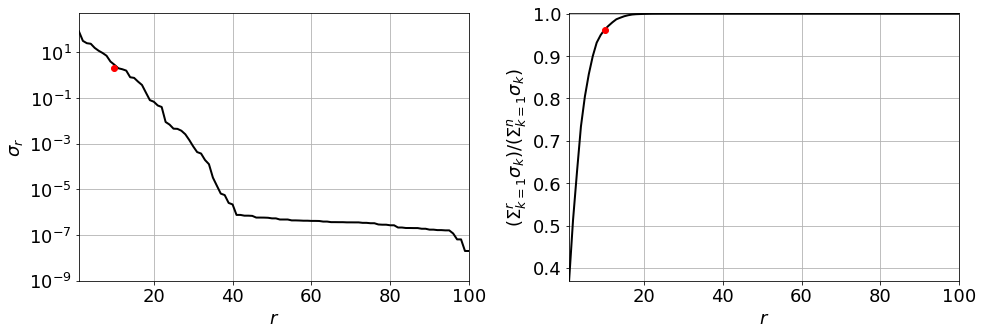

In [8]:
# Figure 9.3

nsvs = len(hsvs)
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(14, 5))
axs[0].semilogy(np.arange(1, nsvs+1), hsvs.real, color='black', linewidth=2)
axs[0].semilogy(r, hsvs[r].real, 'o', color='red', linewidth=2)
axs[0].grid(True)
axs[0].set_ylim((1e-9, 500))
axs[0].set_xlabel(r'$r$')
axs[0].set_ylabel(r'$\sigma_r$')
axs[0].margins(0, 0.001)

axs[1].plot(np.arange(1, nsvs+1), np.cumsum(hsvs.real) / np.sum(hsvs.real), color='black', linewidth=2)
axs[1].plot(r, np.sum(hsvs[:r].real) / np.sum(hsvs.real), 'o', color='red', linewidth=2)
axs[1].set_xlabel(r'$r$')
axs[1].set_ylabel(
    r'$( \Sigma_{k=1}^r \sigma_k ) / ( \Sigma_{k=1}^n\sigma_k )$'
)

axs[1].grid(True)
axs[1].margins(0, 0.001)

plt.tight_layout()

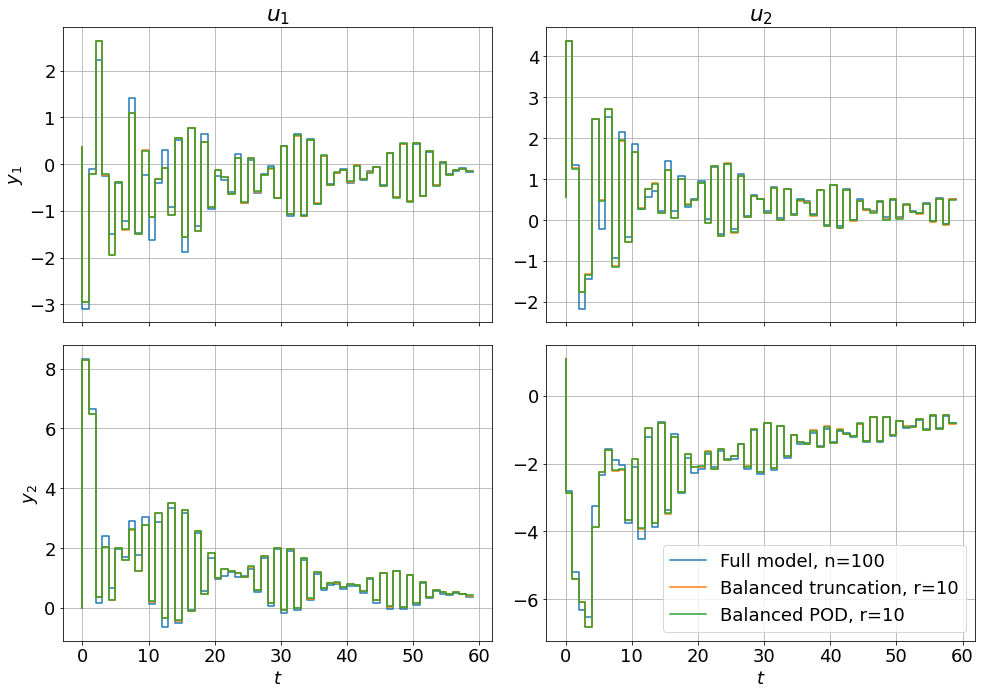

In [9]:
# Figure 9.4

times = np.arange(60)

yout_full, _ = impulse(sys_full, T=times)
yout_bt, _ = impulse(sys_bt, T=times)
yout_bpod, _ = impulse(sys_bpod, T=times)

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(14, 10))
axs = axs.flat
axs[0].step(times, yout_full[:, 0, 0])
axs[0].step(times, yout_bt[:, 0, 0])
axs[0].step(times, yout_bpod[:, 0, 0])
axs[0].grid(True)
axs[0].set_ylabel('$y_1$')
axs[0].set_title('$u_1$')


axs[1].step(times, yout_full[:, 0, 1])
axs[1].step(times, yout_bt[:, 0, 1])
axs[1].step(times, yout_bpod[:, 0, 1])
axs[1].grid(True)
axs[1].set_title('$u_2$')

axs[2].step(times, yout_full[:, 1, 0])
axs[2].step(times, yout_bt[:, 1, 0])
axs[2].step(times, yout_bpod[:, 1, 0])
axs[2].grid(True)
axs[2].set_ylabel('$y_2$')
axs[2].set_xlabel('$t$')

axs[3].step(times, yout_full[:, 1, 1], label=f'Full model, n={n}')
axs[3].step(times, yout_bt[:, 1, 1], label=f'Balanced truncation, r={r}')
axs[3].step(times, yout_bpod[:, 1, 1], label=f'Balanced POD, r={r}');
axs[3].legend()
axs[3].grid(True)
axs[3].set_xlabel('$t$')
plt.tight_layout();